# Import libraries

In [3]:
import pandas as pd
import numpy as np
import transformers
from transformers import AutoTokenizer,AutoModelForQuestionAnswering, TrainingArguments, Trainer
from transformers import default_data_collator
import collections
from tqdm.auto import tqdm

In [4]:
!pip uninstall fsspec -qq -y
!pip install --no-index --find-links ../hf-datasets/wheels datasets -qq
from datasets import Dataset

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-cloud 0.1.13 requires tensorflow<3.0,>=1.15.0, which is not installed.
dask-cudf 21.6.1+2.g101fc0fda4 requires cupy-cuda112, which is not installed.
cudf 21.6.1+2.g101fc0fda4 requires cupy-cuda110, which is not installed.
s3fs 2021.6.1 requires fsspec==2021.06.1, but you have fsspec 2021.6.0 which is incompatible.
pytorch-lightning 1.3.8 requires fsspec[http]!=2021.06.0,>=2021.05.0, but you have fsspec 2021.6.0 which is incompatible.
dask-cudf 21.6.1+2.g101fc0fda4 requires dask<=2021.5.1,>=2021.4.0, but you have dask 2021.6.2 which is incompatible.
dask-cudf 21.6.1+2.g101fc0fda4 requires distributed<=2021.5.1,>=2.22.0, but you have distributed 2021.6.2 which is incompatible.


In [5]:
%env WANDB_DISABLED=True

env: WANDB_DISABLED=True


# Preprocess

In [21]:
class preprocess:
    def __init__(self,path):
        self.path = path
    
    def import_dataset(self):
        df = pd.read_csv(self.path)
        return df
    
    def clean_df(self):
        df = self.import_dataset()
        df['isnull'] = df.context.isnull()
        df = df[df['isnull'] !=True]
        df = df.reset_index(drop=True)
        self.df = df
        
        return df
    
    def no_of_uniq_ids(self):
        df = self.clean_df()
        return df.id.nunique()
    
    def import_tokenizer(self, checkpoint):
        tokenizer = AutoTokenizer.from_pretrained(checkpoint)
        self.tokenizer = tokenizer
        return tokenizer
    
    def token_count_distribution(self, tokenizer):
        df = self.clean_df()
        df['num_tokens_context'] = df['context'].apply(lambda t: len(tokenizer(t)['input_ids']))
        return df['num_tokens_context'].hist()
    
    def convert_answers(self,r):
        start = r[0]
        text = r[1]
        return {
            'answer_start': [start],
            'text': [text]
        }
    
    def shuffle(self):
        df = self.clean_df()
        df = df.sample(frac=1, random_state=42)
        df['answers'] = df[['answer_start', 'answer_text']].apply(self.convert_answers, axis=1)
        return df
        
    def split_data(self):
        df = self.shuffle()
        df_train = df[:-64].reset_index(drop=True)
        df_valid = df[-64:].reset_index(drop=True)
        train_dataset = Dataset.from_pandas(df_train)
        valid_dataset = Dataset.from_pandas(df_valid)
        
        return train_dataset,valid_dataset
    
    
    def prepare_train_features(self,examples):
        max_length = 384 
        doc_stride = 128
        pad_on_right = tokenizer.padding_side == "right"
    
        examples["question"] = [q.lstrip() for q in examples["question"]]

        tokenized_examples = tokenizer(
            examples["question" if pad_on_right else "context"],
            examples["context" if pad_on_right else "question"],
            truncation="only_second" if pad_on_right else "only_first",
            max_length=max_length,
            stride=doc_stride,
            return_overflowing_tokens=True,
            return_offsets_mapping=True,
            padding="max_length",
        )

        sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    
        offset_mapping = tokenized_examples.pop("offset_mapping")

        tokenized_examples["start_positions"] = []
        tokenized_examples["end_positions"] = []

        for i, offsets in enumerate(offset_mapping):
            input_ids = tokenized_examples["input_ids"][i]
            cls_index = input_ids.index(tokenizer.cls_token_id)

            sequence_ids = tokenized_examples.sequence_ids(i)

            sample_index = sample_mapping[i]
            answers = examples["answers"][sample_index]
            if len(answers["answer_start"]) == 0:
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                start_char = answers["answer_start"][0]
                end_char = start_char + len(answers["text"][0])

                token_start_index = 0
                while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                    token_start_index += 1

                token_end_index = len(input_ids) - 1
                while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                    token_end_index -= 1

                if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                    tokenized_examples["start_positions"].append(cls_index)
                    tokenized_examples["end_positions"].append(cls_index)
                else:
                    
                    while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                        token_start_index += 1
                    tokenized_examples["start_positions"].append(token_start_index - 1)
                    while offsets[token_end_index][1] >= end_char:
                        token_end_index -= 1
                    tokenized_examples["end_positions"].append(token_end_index + 1)

        return tokenized_examples
        
    def tokenized_df(self):
        train_dataset,valid_dataset = self.split_data()
        tokenized_train_ds = train_dataset.map(self.prepare_train_features, batched=True, remove_columns=train_dataset.column_names)
        tokenized_valid_ds = valid_dataset.map(self.prepare_train_features, batched=True, remove_columns=train_dataset.column_names)
        return tokenized_train_ds,tokenized_valid_ds

    
    

In [22]:
preprocess2 = preprocess('df_tam3.csv')
tokenizer = preprocess2.import_tokenizer('xlm-roberta-base-squad2')
train_dataset,valid_dataset = preprocess2.split_data()
tokenized_train_ds,tokenized_valid_ds = preprocess2.tokenized_df()

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1492 > 512). Running this sequence through the model will result in indexing errors


<AxesSubplot:>

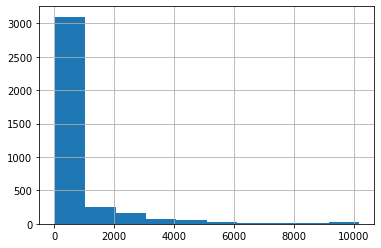

In [23]:
preprocess2.token_count_distribution(tokenizer)

# Model Building

In [8]:
class model_building:
    
    def __init__(self,model_checkpoint):
        self.model_checkpoint = model_checkpoint
    
    def import_model(self):
        model = AutoModelForQuestionAnswering.from_pretrained(self.model_checkpoint)
        return model
    
    def training_parameters(self,learning_rate=2e-5,batch_size = 4,weight_decay=0.01,num_train_epochs=1):
        args = TrainingArguments(
            f"tamil-qa",
            evaluation_strategy = "epoch",
            save_strategy = "epoch",
            learning_rate=learning_rate,
            warmup_ratio=0.1,
            gradient_accumulation_steps=8,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=num_train_epochs,
            weight_decay=weight_decay,
        )
        return args
    
    def train_model(self, model, args, tokenized_train_ds,tokenized_valid_ds):
        data_collator = default_data_collator
        trainer = Trainer(
            model,
            args,
            train_dataset=tokenized_train_ds,
            eval_dataset=tokenized_valid_ds,
            data_collator=data_collator,
            tokenizer=tokenizer,
        )
        trainer.train()
        
        return trainer

In [9]:
modelbuild = model_building('xlm-roberta-squad2/deepset/xlm-roberta-base-squad2')
model = modelbuild.import_model()
args = modelbuild.training_parameters(num_train_epochs=5)
trainer = modelbuild.train_model(model, args, tokenized_train_ds,tokenized_valid_ds)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
0,No log,1.188149
1,0.970500,1.145816
2,0.637100,1.294962
3,0.426600,1.305490
4,0.426600,1.434978


# Testing

In [10]:
class answer_extraction:
    
    def __init__(self, valid_dataset):
        self.valid_dataset = valid_dataset
    
    def prepare_validation_features(self,examples):
        max_length = 384 
        doc_stride = 128
        pad_on_right = tokenizer.padding_side == "right"
        
        examples["question"] = [q.lstrip() for q in examples["question"]]

        tokenized_examples = tokenizer(
            examples["question" if pad_on_right else "context"],
            examples["context" if pad_on_right else "question"],
            truncation="only_second" if pad_on_right else "only_first",
            max_length=max_length,
            stride=doc_stride,
            return_overflowing_tokens=True,
            return_offsets_mapping=True,
            padding="max_length",
        )

        sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

        tokenized_examples["example_id"] = []

        for i in range(len(tokenized_examples["input_ids"])):
            sequence_ids = tokenized_examples.sequence_ids(i)
            context_index = 1 if pad_on_right else 0

            sample_index = sample_mapping[i]
            tokenized_examples["example_id"].append(examples["id"][sample_index])

            tokenized_examples["offset_mapping"][i] = [
                (o if sequence_ids[k] == context_index else None)
                for k, o in enumerate(tokenized_examples["offset_mapping"][i])
            ]

        return tokenized_examples
    
    def apply_validation_feature(self):
        valid_dataset = self.valid_dataset
        validation_features = valid_dataset.map(
            self.prepare_validation_features,
            batched=True,
            remove_columns=valid_dataset.column_names
        )
        return validation_features
        
    def valid(self):
        validation_features = self.apply_validation_feature()
        valid_feats_small = validation_features.map(lambda example: example, remove_columns=['example_id', 'offset_mapping'])
        return valid_feats_small
    
    def raw_predict(self,trainer):
        valid_feats_small = self.valid()
        raw_predictions = trainer.predict(valid_feats_small)
        return raw_predictions
    
    def postprocess_qa_predictions(self, raw_predictions, n_best_size = 20, max_answer_length = 30):
        examples = self.valid_dataset
        features = self.apply_validation_feature()
        
        all_start_logits, all_end_logits = raw_predictions
        example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
        features_per_example = collections.defaultdict(list)
        
        for i, feature in enumerate(features):
            features_per_example[example_id_to_index[feature["example_id"]]].append(i)

        predictions = collections.OrderedDict()

        print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

        for example_index, example in enumerate(tqdm(examples)):
            feature_indices = features_per_example[example_index]

            min_null_score = None 
            valid_answers = []

            context = example["context"]
            for feature_index in feature_indices: 
                start_logits = all_start_logits[feature_index]
                end_logits = all_end_logits[feature_index]
              
                offset_mapping = features[feature_index]["offset_mapping"]

                cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
                feature_null_score = start_logits[cls_index] + end_logits[cls_index]
                if min_null_score is None or min_null_score < feature_null_score:
                    min_null_score = feature_null_score

                start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
                end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
                for start_index in start_indexes:
                    for end_index in end_indexes:
                        if (
                            start_index >= len(offset_mapping)
                            or end_index >= len(offset_mapping)
                            or offset_mapping[start_index] is None
                            or offset_mapping[end_index] is None
                        ):
                            continue
                        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                            continue

                        start_char = offset_mapping[start_index][0]
                        end_char = offset_mapping[end_index][1]
                        valid_answers.append(
                            {
                                "score": start_logits[start_index] + end_logits[end_index],
                                "text": context[start_char: end_char]
                            }
                        )

            if len(valid_answers) > 0:
                best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
            else:
               
                best_answer = {"text": "", "score": 0.0}

            predictions[example["id"]] = best_answer["text"]

        return predictions

In [11]:
def compute_exact_match(row):
    return int(row[0] == row[1])

def jaccard(row): 
    str1 = row[0]
    str2 = row[1]
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

def compute_f1(row):
    truth = row[0]
    prediction = row[1]
    pred_tokens = prediction.split()
    truth_tokens = truth.split()
    
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)

In [13]:
testing2 = answer_extraction(valid_dataset)
validation_features = testing2.apply_validation_feature()
valid_feats_small = testing2.valid()
raw_predictions = testing2.raw_predict(trainer)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/169 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/169 [00:00<?, ?ex/s]

In [14]:
predictions = testing2.postprocess_qa_predictions( 
                                    raw_predictions.predictions, n_best_size = 20, 
                                    max_answer_length = 30)

  0%|          | 0/1 [00:00<?, ?ba/s]

Post-processing 64 example predictions split into 169 features.


  0%|          | 0/64 [00:00<?, ?it/s]

In [15]:
references = [{"id": ex["id"], "answer_text": ex["answers"]['text'][0]} for ex in valid_dataset]
res = pd.DataFrame(references)
res['prediction'] = res['id'].apply(lambda r: predictions[r])


In [18]:
res['jaccard'] = res[['answer_text', 'prediction']].apply(jaccard, axis=1)
res ['EM'] = res[['answer_text', 'prediction']].apply(compute_exact_match, axis=1)
res ['F1'] = res[['answer_text', 'prediction']].apply(compute_f1, axis=1)
res.tail()

,id,answer_text,prediction,jaccard,EM,F1
59,e693ffa1,720 களுக்குப் பிறகு,கிமு 720,0.25,0,0.400000
60,83f94fe8,உயிரியல்,தாமிரம் உயிரியல்,0.50,0,0.666667
61,08fc5f48,11,11,1.00,0,1.000000
62,28f9e6ea,கோல்கொண்டா,கோல்கொண்டா,1.00,0,1.000000
63,1fc78dff,ஹிரூ,ஹிரூ,1.00,0,1.000000


In [19]:
print('F1 Score: ',res.F1.mean())
print('Jaccard score: ',res.jaccard.mean())
print('Exact match score: ', res.EM.mean())

F1 Score:  0.5772845643939393
Jaccard score:  0.5378348214285714
Exact match score:  0.125
